In [1]:
import sys
sys.path.append('../')
from torch.distributions.bernoulli import Bernoulli
from torch.distributions.geometric import Geometric
from Code.envs.permutations2 import make_batch
import torch
import torch.nn as nn
import torch.optim as optim
import time
from collections import OrderedDict

from PIL import Image
import numpy as np

In [2]:
BATCH_SIZE = 64#128

USE_JIT = False

#TODO: test device
device = torch.device('cpu')

SEQ_LEN = 30
CHAR_DUR = 5 #0 #100
RESET_PROB = 0.1 #0.2

perm_num = 4
n_input = perm_num**2+1+CHAR_DUR
n_out = perm_num**2
n_control = 100
n_mem = 20 #100


In [3]:
spec2 = {'beta': 0.9,
   'lr': 0.001,
   'lr_decay': 0.8,
   '1-beta': False,
   'ported_weights': True,
   'NoBias': True,
   'iterations': 5000,
   'batch_size': 128,
   'mem_beta': 1,
   'spkfn': 'ss',
   'decay_out': False,
   'architecture': '1L',
   'control_neuron': 'LIF',
   'mem_neuron': 'Cooldown'}

spec = {'beta': 0.9,
   'lr': 0.01,
   'lr_decay': 0.8,
   '1-beta': False,
   'ported_weights': True,
   'NoBias': True,
   'iterations': 5000,
   'batch_size': 128,
   'mem_beta': 0.95,
   'spkfn': 'bellec',
   'decay_out': False,
   'architecture': '2L',
   'control_neuron': 'LIF',
   'mem_neuron': 'Adaptive'}

spec['iterations'] = 15000
#spec['mem_beta'] = 0.9985
#spec['mem_neuron'] = 'FlipFlop'
#spec['1-beta'] = 'improved'
spec['lr'] = 0.001
spec['lr_decay'] = 0.9
spec['beta'] = 0.8
spec['mem_beta'] = 0.8

ADAP_DECAY = np.exp(-1/5)

In [4]:
from Code.everything3 import DynNetwork, OuterWrapper, BaseNeuron, SequenceWrapper, ParallelNetwork, \
 SeqOnlySpike, CooldownNeuron, OutputNeuron, LIFNeuron, NoResetNeuron, AdaptiveNeuron, FlipFlopNeuron, ParallelNetwork2


built_config = {
    'target_rate': 0.01,
    'BETA': spec['beta'],
    'OFFSET': 7, # TODO: was 3 for config24
    'SPIKE_FN': spec['spkfn'],
    '1-beta': spec['1-beta'],
    'ADAPDECAY': ADAP_DECAY, #0.9985,
    'ADAPSCALE': 180
}

#TODO: changed here
built_config['ADAPDECAY'] = 0.99

mem_config = {
    **built_config,
    'BETA': spec['mem_beta']
}



control_lookup = {
    'LIF': LIFNeuron,
    'Disc': SeqOnlySpike,
    'NoReset': NoResetNeuron
}

mem_lookup = {
    'Adaptive': AdaptiveNeuron,
    'Cooldown': CooldownNeuron,
    'NoReset': NoResetNeuron,
    'FlipFlop': FlipFlopNeuron
}

control_neuron = control_lookup[spec['control_neuron']](n_control, built_config)
mem_neuron = mem_lookup[spec['mem_neuron']](n_mem, mem_config)
out_neuron = OutputNeuron(n_control+n_mem, built_config) if spec['decay_out'] else BaseNeuron(n_control+n_mem, built_config)


loop_2L = OrderedDict([
    ('input', n_input),
    ('control', [['input', 'mem'], control_neuron, nn.Linear]),
    ('mem', [['control'], mem_neuron, nn.Linear]),
    ('output', [['control', 'mem'], out_neuron, None]),
])

loop_2L = OrderedDict([
    ('input', (n_input, 0.1)),
    ('control', [[('input', 0.8), ('mem', 0.2)], control_neuron, nn.Linear]),
    ('mem', [['control'], mem_neuron, nn.Linear]),
    ('output', [['control', 'mem'], out_neuron, None]),
])


loop_1L = OrderedDict([
    ('input', n_input),
    ('control', [['input', 'control', 'mem'], control_neuron, nn.Linear]),
    ('mem', [['input', 'control', 'mem'], mem_neuron, nn.Linear]),
    ('output', [['control', 'mem'], out_neuron, None]),
])

loop = loop_1L if spec['architecture'] == '1L' else loop_2L

outer = OrderedDict([
    ('input', n_input),
    ('loop', [['input'], SequenceWrapper(ParallelNetwork2(loop, bias=(not spec['NoBias']))), None]),
    ('output', [['loop'], BaseNeuron(n_out, None), nn.Linear]),
])

model = OuterWrapper(DynNetwork(outer), device)


#loop_model = OuterWrapper(make_SequenceWrapper(ParallelNetwork(loop), USE_JIT), device, USE_JIT)

#final_linear = nn.Linear(n_control+n_mem, 10).to(device)
'''
if spec['ported_weights']:
    o_weights = pickle.load(open('weight_transplant_enc', 'rb'))

    o1 = torch.tensor(o_weights['RecWeights/RecurrentWeight:0']).t()
    o2 = torch.tensor(o_weights['InputWeights/InputWeight:0']).t()
    o3 = torch.cat((o2, o1), dim=1)
    with torch.no_grad():
        model.pretrace.layers.loop.model.layers.control_synapse.weight.data[:,:300] = o3[:120] if spec['architecture'] == '1L' else o3[:120, :181]
        model.pretrace.layers.loop.model.layers.mem_synapse.weight.data[:,:300] = o3[120:] if spec['architecture'] == '1L' else o3[120:, 180:]
        model.pretrace.layers.output_synapse.weight.data = torch.tensor(o_weights['out_weight:0']).t()
'''
params = list(model.parameters())

model.to(device)


OrderedDict([('control', [[('input', 0.8), ('mem', 0.2)], LIFNeuron(), <class 'torch.nn.modules.linear.Linear'>]), ('mem', [[('control', 1)], AdaptiveNeuron(), <class 'torch.nn.modules.linear.Linear'>]), ('output', [[('control', 1), ('mem', 1)], BaseNeuron(), None])])


OuterWrapper(
  (model): DynNetwork(
    (layers): ModuleDict(
      (loop): SequenceWrapper(
        (model): ParallelNetwork2(
          (layers): ModuleDict(
            (control): LIFNeuron()
            (control_synapse): Linear(in_features=38, out_features=100, bias=True)
            (mem): AdaptiveNeuron()
            (mem_synapse): Linear(in_features=100, out_features=20, bias=True)
            (output): BaseNeuron()
          )
        )
      )
      (output_synapse): Linear(in_features=120, out_features=16, bias=True)
      (output): BaseNeuron()
    )
  )
)

In [4]:
from Code.everything3 import DynNetwork, OuterWrapper, LSTMWrapper, MeanModule, BaseNeuron

lstm_size = 32

outer = OrderedDict([
    ('input', n_input),
    ('lstm', [['input'], LSTMWrapper(n_input, lstm_size), None]),
    ('output', [['lstm'], BaseNeuron(n_out, None), nn.Linear]),
])

model = OuterWrapper(DynNetwork(outer), device, USE_JIT)

#with torch.no_grad():
#    model.model.layers.lstm.lstm.bias_hh_l0[:256] += 3



params = list(model.parameters())


model.to(device)

OuterWrapper(
  (model): DynNetwork(
    (layers): ModuleDict(
      (lstm): LSTMWrapper(
        (lstm): LSTM(22, 32)
      )
      (output_synapse): Linear(in_features=32, out_features=16, bias=True)
      (output): BaseNeuron()
    )
  )
)

In [4]:
from Code.everything3 import DynNetwork, OuterWrapper, LSTMWrapper, MeanModule, BaseNeuron
model = OuterWrapper(torch.load('../models/perm_lstm2'), device, USE_JIT)
params = list(model.parameters())


In [5]:
lr = spec['lr']
optimizer = optim.Adam(params, lr=lr)
#bce = nn.BCEWithLogitsLoss(reduction='none')
ce = nn.CrossEntropyLoss() #reduction='none'


ITERATIONS = spec['iterations']#36000

In [6]:
stats = {
    'grad_norm': [],
    'loss': [],
    'acc': [],
    'batch_var': [],
    'val': []
}

grad_norm_history = []
def record_norm():
    norms = []
    for p in params:
        norms.append(p.grad.norm().item())
    stats['grad_norm'].append(torch.tensor(norms).norm().item())


In [7]:
'''
#store_dist = (lambda : Geometric(torch.tensor([0.2], device=device)).sample().int().item()+1)
recall_dist = (lambda : Geometric(torch.tensor([0.2], device=device)).sample().int().item()+1)
store_dist = (lambda : 1)


with torch.no_grad():
    rythm = torch.zeros([CHAR_DUR], device=device)
    rythm[0] = 1
    rythm = rythm.expand(SEQ_LEN, CHAR_DUR).reshape(SEQ_LEN*CHAR_DUR, 1, 1).expand(SEQ_LEN*CHAR_DUR, BATCH_SIZE, 1)
    #rythm = rythm.view(1,5,1,1).expand([SEQ_LEN, CHAR_DUR, BATCH_SIZE, 1]).view(SEQ_LEN*CHAR_DUR, BATCH_SIZE, 1)
'''
with torch.no_grad():
    rythm = torch.diag(torch.ones([CHAR_DUR], device=device))
    rythm = rythm.expand(SEQ_LEN, CHAR_DUR, CHAR_DUR).reshape(SEQ_LEN*CHAR_DUR, 1, CHAR_DUR).expand(SEQ_LEN*CHAR_DUR, BATCH_SIZE, CHAR_DUR)

In [8]:


start = time.time()
i = 1
sumloss = 0
sumacc = 0

while i < ITERATIONS:
    batchstart = time.time()
    optimizer.zero_grad()
    input, target = make_batch(BATCH_SIZE, SEQ_LEN, RESET_PROB, device, perm_num)
    #data = data.repeat_interleave(CHAR_DUR, 0)

    recall = torch.ones([1], device=device).expand(SEQ_LEN, BATCH_SIZE, perm_num)

    input = input.repeat_interleave(CHAR_DUR, 0)
    input = torch.cat((input, rythm), dim=-1)

    #TODO: repeat data over

    output, _ = model(input)
    output = output.view(SEQ_LEN, CHAR_DUR, BATCH_SIZE, perm_num, perm_num).mean(dim=1)
    out2 = output.transpose(-1, -2)
    loss1 = ce(output.view(-1, perm_num), target[0].view(-1))
    loss2 = ce(out2.reshape(-1, perm_num), target[1].view(-1))
    loss = ((loss1+loss2)*recall.view(-1)).sum()/recall.sum()
    #TODO: mask with recall
    loss.backward()
    optimizer.step()

    acc1 = (output.argmax(dim=-1) == target[0]).all(dim=-1).float().mean().item()
    acc2 = (out2.argmax(dim=-1) == target[1]).all(dim=-1).float().mean().item()


    with torch.no_grad():
        record_norm()
        stats['loss'].append(loss.item())
        #acc = ((((output > 0).float() == target).float()*recall).sum()/recall.sum()).item()
        #stats['acc'].append(acc)
        batch_var = 3 #out_final.var(0).mean().item()
        #stats['batch_var'].append(batch_var)

        #print(loss.item(), acc1, acc2)


    sumloss += loss.item()
    sumacc += acc1
    if i%20 == 0:
        print(sumacc/20, i)
        #print(loss.item(), sumloss/20, sumacc/20, time.time()-batchstart, batch_var) #torch.argmax(outputs[-1], 1).float().var()
        sumloss = 0
        sumacc = 0
    if i%100 == 0:
        validate()
    if i%2500 == 0:
        lr = lr * spec['lr_decay']
        optimizer = optim.Adam(params, lr=lr)
        print('Learning Rate: ', lr)
    i += 1
    #config['stats'] = stats
    #config['progress'] = i
    #with open('configs/' + run_id + '.json', 'w') as config_file:
    #    json.dump(config, config_file, indent=2)
    #model.save('models/'+run_id)


print('Total time: ', time.time()-start)


0.001328125043073669 20
0.012395833249320276 40
0.03843749994412064 60
0.04096354190260172 80
0.04661458320915699 100


NameError: name 'validate' is not defined

In [9]:
test_data = make_batch(1, 13, store_dist, recall_dist, device)

TypeError: make_batch() takes 4 positional arguments but 5 were given

In [ ]:
a = test_data[:, 0 ,0].nonzero()

In [ ]:
b = test_data[:a, 0, 1].nonzero()[-1]

In [ ]:
test_data[b, 0, 2] == test_data[a, 0, 3]


In [10]:
seql = 100
res_prob = 0.
with torch.no_grad():
    nrythm = torch.diag(torch.ones([CHAR_DUR], device=device))
    nrythm = nrythm.expand(seql, CHAR_DUR, CHAR_DUR).reshape(seql*CHAR_DUR, 1, CHAR_DUR).expand(seql*CHAR_DUR, BATCH_SIZE, CHAR_DUR)

def validate():
    #seql = SEQ_LEN
    with torch.no_grad():
        input, target = make_batch(BATCH_SIZE, seql, res_prob, device, perm_num)
        input = input.repeat_interleave(CHAR_DUR, 0)
        input = torch.cat((input, nrythm), dim=-1)

    #TODO: repeat data over
        output, _, log = model(input, logging=True)
        output = output.view(seql, CHAR_DUR, BATCH_SIZE, perm_num, perm_num).mean(dim=1)
        print('Validation: ', (output.argmax(dim=-1) == target[0]).all(dim=-1).float().mean().item())

In [11]:
validate()


Validation:  0.3695312440395355


In [14]:
ar_length = input.shape[0]
array_list = [input, log['loop']['control'], log['loop']['mem'], log['output']] #log['loop']['output']
array_list2 = []
for ar in array_list:
    array_list2.append(ar[:, 0])
    array_list2.append(torch.ones((ar_length, 1), device=input.device) * 0.5)
big_ar = torch.cat(array_list2[:-1], dim=1).detach() * 255
img = Image.fromarray(big_ar.numpy().astype(np.uint8), 'L')

In [15]:
img.size

(237, 25)

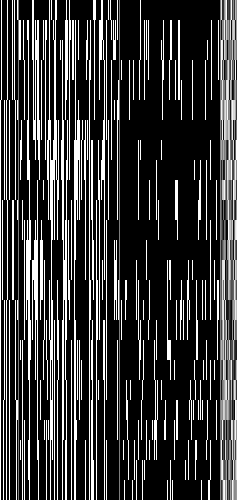

In [17]:
img.resize((237, 500))

In [ ]:
log['loop']['control'].mean()

In [ ]:
log['loop']['mem'].mean()



In [ ]:
model.model.layers.loop.model.layers.control_synapse.weight.var()

In [ ]:
model.model.layers.loop.model.layers.mem_synapse.weight.var()

In [ ]:
model.model.layers.loop.model.layers.control_synapse.weight.var() * log['loop']['mem'].mean()


In [14]:
#model.save('../models/perm_lstm2')

In [4]:
ADAP_DECAY

0.8187307530779818

In [22]:

output.shape

torch.Size([25, 128, 16])